In [1]:
import numpy as np
import tensorflow as tf
import torch
tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -
     


2023-10-16 20:21:40.237398: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 20:21:40.238789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 20:21:40.267505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 20:21:40.267547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 20:21:40.267567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Retrieving speedtest.net configuration...
Testing from Viettel Group (116.109.33.215)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by SCTV Co., Ltd (Ho Chi Minh) [9.23 km]: 7.404 ms
Testing download speed................................................................................
Download: 20.10 Mbit/s
Testing upload speed......................................................................................................
Upload: 20.50 Mbit/s


In [2]:
TRAIN_PATH = 'VLSP2018-SA-train-dev-test/csv/train.csv'
VAL_PATH = 'VLSP2018-SA-train-dev-test/csv/dev.csv'
TEST_PATH = 'VLSP2018-SA-train-dev-test/csv/test.csv'


In [3]:
import pandas as pd
def read_csv(url):
    df = pd.read_csv(url)

    X = df.pop('review')
    y = df.replace({np.nan: 0, 
                    'negative': 1, 
                    'neutral': 2, 
                    'positive': 3}).astype(np.uint8)

    print('X.shape:', X.shape, 'y.shape:', y.shape)
    return X, y

Xtrain, ytrain = read_csv(TRAIN_PATH)
Xdev,   ydev   = read_csv(VAL_PATH)
Xtest,  ytest  = read_csv(TEST_PATH)

X.shape: (2961,) y.shape: (2961, 12)
X.shape: (1290,) y.shape: (1290, 12)
X.shape: (500,) y.shape: (500, 12)


In [4]:
aspects = ['FOOD#PRICES',
           'FOOD#QUALITY',
           'FOOD#STYLE&OPTIONS',
           'DRINKS#PRICES',
           'DRINKS#QUALITY',
           'DRINKS#STYLE&OPTIONS',
           'RESTAURANT#PRICES',
           'RESTAURANT#GENERAL',
           'RESTAURANT#MISCELLANEOUS',
           'SERVICE#GENERAL',
           'AMBIENCE#GENERAL',
           'LOCATION#GENERAL']

sentiments = ['-', 'o', '+']

def mo2ml(y):
    """Convert multi-output to multi-label data
    """
    newcols = [f'{a} {s}' for a in aspects for s in sentiments]

    nrows, ncols = len(y), len(newcols)
    ml = pd.DataFrame(np.zeros((nrows, ncols), dtype='bool'),
                      columns=newcols)
    
    for i, a in enumerate(aspects):
        for j in range(1, 4):
            indices = y[a] == j
            ml.iloc[indices, i * 3 + j - 1] = True

    return ml

In [5]:
ytrain_ml = mo2ml(ytrain)
ydev_ml   = mo2ml(ydev)
ytest_ml  = mo2ml(ytest)

In [6]:
def mo2df(y):
    if isinstance(y, pd.DataFrame):
        return y
    return pd.DataFrame(y, columns=aspects)

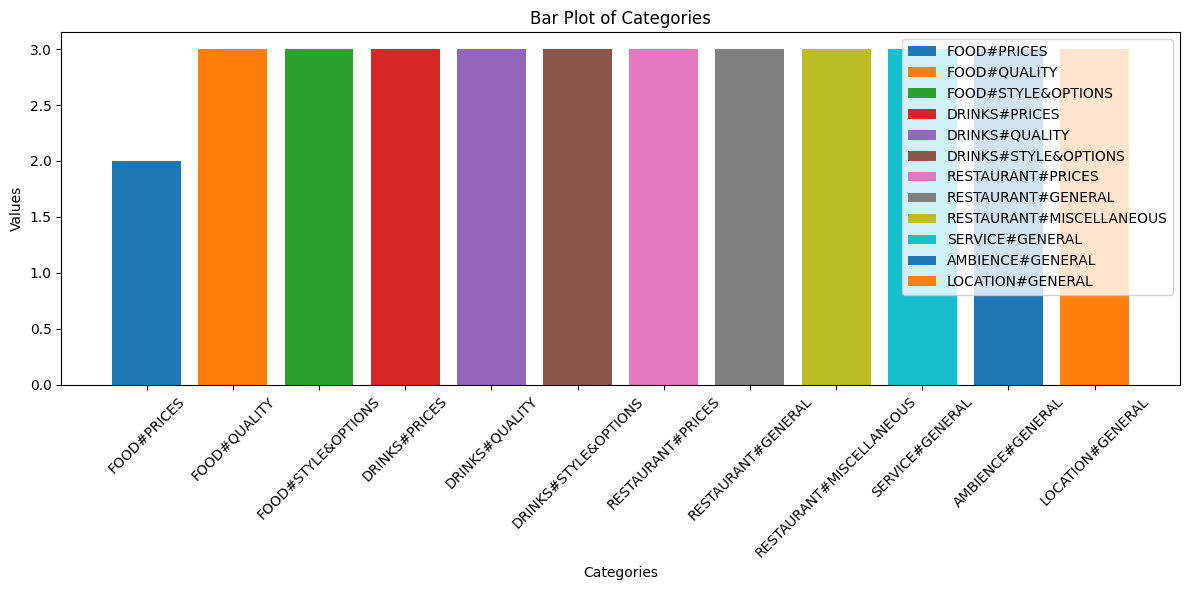

In [9]:
import matplotlib.pyplot as plt
ytrain_transposed = ytrain.T
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate through each category and plot the values
for category_index, category_name in dict(enumerate(aspects)).items():
    ax.bar(category_name, ytrain_transposed[category_index], label=category_name)

# Set labels, legend, and title
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Bar Plot of Categories')
ax.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.9)

xtrain_baseCV = vectorizer.fit_transform(Xtrain) 
xdev_baseCV = vectorizer.transform(Xdev) 
xtest_baseCV = vectorizer.transform(Xtest) 

In [18]:
sample_vector = xtrain_baseCV[0]

# Retrieve terms and their indices from the vocabulary
vocab_terms = {index: term for term, index in vectorizer.vocabulary_.items()}

# For each non-zero entry in the sample vector, print the term and its frequency value
for index in sample_vector.indices:
    print(f"Term: {vocab_terms[index]}, CV value: {sample_vector[0, index]}")

Term: ảnh, CV value: 1
Term: chụp, CV value: 3
Term: từ, CV value: 1
Term: hôm, CV value: 2
Term: qua, CV value: 2
Term: đi, CV value: 2
Term: chơi, CV value: 1
Term: với, CV value: 3
Term: gia, CV value: 1
Term: đình, CV value: 1
Term: và, CV value: 1
Term: nhà, CV value: 1
Term: họ, CV value: 1
Term: hàng, CV value: 1
Term: đang, CV value: 1
Term: sống, CV value: 1
Term: tại, CV value: 1
Term: sài, CV value: 1
Term: gòn, CV value: 1
Term: ăn, CV value: 4
Term: trưa, CV value: 1
Term: muộn, CV value: 1
Term: ai, CV value: 1
Term: cũng, CV value: 1
Term: đói, CV value: 2
Term: hết, CV value: 1
Term: nên, CV value: 2
Term: lúc, CV value: 1
Term: có, CV value: 1
Term: đồ, CV value: 2
Term: là, CV value: 1
Term: nhào, CV value: 1
Term: vô, CV value: 1
Term: liền, CV value: 1
Term: bởi, CV value: 1
Term: vậy, CV value: 1
Term: mới, CV value: 1
Term: quên, CV value: 1
Term: các, CV value: 1
Term: phần, CV value: 1
Term: gọi, CV value: 1
Term: thêm, CV value: 1
Term: nước, CV value: 1
Term: 

In [12]:
from sklearn.metrics import f1_score, classification_report


def quick_f1(y_true, y_pred):
    y_pred = mo2ml(mo2df(y_pred))
    return round(f1_score(y_true, y_pred, average='micro', zero_division=0), 4)

def evaluate(model, X, y, average='micro'):
    yb_true  = mo2ml(y)

    yb_pred  = mo2df(model.predict(X))
    yb_pred  = mo2ml(yb_pred)

    return classification_report(yb_true, yb_pred, zero_division=0)

In [25]:
from sklearn.linear_model import SGDClassifier
import optuna 
from optuna.samplers import TPESampler 
from sklearn.multioutput import MultiOutputClassifier as MOC 

def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key='best_model', value=trial.user_attrs['model'])

      
def logistic_objective(trial):
    params = dict(
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        alpha=trial.suggest_float('alpha', 1e-7, 1e-2, log=True),  # Add alpha for L2 regularization.
        random_state=5,
    )

    clf = MOC(SGDClassifier(loss='log_loss', max_iter=200, **params))  
    clf.fit(xtrain_baseCV, ytrain)
    trial.set_user_attr(key="model", value=clf)

    y_pred = clf.predict(xdev_baseCV)
    return quick_f1(ydev_ml, y_pred)

sampler = TPESampler(seed=221) 
logistic_study = optuna.create_study(sampler=sampler, direction='maximize') 
logistic_study.optimize(logistic_objective, n_trials=50, callbacks=[callback])

clf = logistic_study.user_attrs['best_model']

print(evaluate(clf, xtest_baseCV, ytest))

print('train:', quick_f1(ytrain_ml, clf4.predict(xtrain_baseCV)))
print('dev:  ', quick_f1(ydev_ml  , clf4.predict(xdev_baseCV)))
print('test:', quick_f1(ytest_ml  , clf4.predict(xtest_baseCV)))

print(clf.estimators_[0].get_params())
print(logistic_study.best_params)

[I 2023-10-17 01:14:17,284] A new study created in memory with name: no-name-e072030f-0bbd-43d9-8829-aee5c6ee8dda
[I 2023-10-17 01:14:17,970] Trial 0 finished with value: 0.622 and parameters: {'class_weight': None, 'alpha': 2.086730993171339e-07}. Best is trial 0 with value: 0.622.
[I 2023-10-17 01:14:18,676] Trial 1 finished with value: 0.6207 and parameters: {'class_weight': None, 'alpha': 4.000963741781517e-07}. Best is trial 0 with value: 0.622.
[I 2023-10-17 01:14:19,451] Trial 2 finished with value: 0.6478 and parameters: {'class_weight': None, 'alpha': 0.00010411370694542619}. Best is trial 2 with value: 0.6478.
[I 2023-10-17 01:14:20,454] Trial 3 finished with value: 0.6344 and parameters: {'class_weight': None, 'alpha': 1.0372194842606338e-05}. Best is trial 2 with value: 0.6478.
[I 2023-10-17 01:14:21,773] Trial 4 finished with value: 0.6095 and parameters: {'class_weight': 'balanced', 'alpha': 4.452235708985503e-06}. Best is trial 2 with value: 0.6478.
[I 2023-10-17 01:14:2

              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.52      0.46      0.49       175
           2       0.50      0.59      0.54       128
           3       0.00      0.00      0.00        11
           4       0.48      0.26      0.33        43
           5       0.87      0.96      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.92      0.82       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.82      0.17      0.28        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.50    

In [33]:
from functools import partial
import demoji
from flashtext import KeywordProcessor
from sklearn.base import BaseEstimator, TransformerMixin
import unicodedata


class TextCleanerBase(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

        # Create preprocessing function
        self.normalize_unicode = partial(unicodedata.normalize, 'NFC')
            
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.Series(X)

        return X.apply(str.lower) \
                .apply(remove_emojis) \
                .apply(self.normalize_unicode)

def remove_emojis(text):
    return demoji.replace(text, '')

In [34]:
cleaner_base  = TextCleanerBase()

xtrain_basecl = cleaner_base.transform(Xtrain)
xdev_basecl   = cleaner_base.transform(Xdev)
xtest_basecl  = cleaner_base.transform(Xtest)

xtrain_basecl

0       _ ảnh chụp từ hôm qua, đi chơi với gia đình và...
1       _hương vị thơm ngon, ăn cay cay rất thích, nêm...
2       - 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...
3       - các bạn nhìn cái chảo này có to không - trên...
4       - cháo: có nhiều hương cho các bạn chọn, nhưng...
                              ...                        
2956                                 y hệt vị đà lạt luôn
2957    yaourt trái cây mát lạnh, có thêm viên kem ở t...
2958               zumi.... zumi lễ vẫn bán nhé mọi người
2959    set này có 2 tầng bánh và 1 ấm trà mà chỉ có 1...
2960    lạnh trời thế này mà ngồi ăn chả cá lăng xèo x...
Name: review, Length: 2961, dtype: object

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             min_df=2, max_df=0.9)

# x data using basic clean up class and basic features extrator
xtrain_basecl_basef = vectorizer.fit_transform(xtrain_basecl)
xdev_basecl_basef   = vectorizer.transform(xdev_basecl)
xtest_basecl_basef  = vectorizer.transform(xtest_basecl)


In [36]:
sample_vector = xtrain_basecl_basef[0]
print(sample_vector)

# Retrieve terms and their indices from the vocabulary
vocab_terms = {index: term for term, index in vectorizer.vocabulary_.items()}

# For each non-zero entry in the sample vector, print the term and its TF-IDF value
for index in sample_vector.indices:
    print(f"Term: {vocab_terms[index]}, TF-IDF value: {sample_vector[0, index]}")

  (0, 25176)	0.11312900190971692
  (0, 28680)	0.11312900190971692
  (0, 7610)	0.10900675315011188
  (0, 19449)	0.09587705653497455
  (0, 21440)	0.10580928860260154
  (0, 32167)	0.11312900190971692
  (0, 29335)	0.09587705653497455
  (0, 33256)	0.10900675315011188
  (0, 5389)	0.10098791670329485
  (0, 21292)	0.10900675315011188
  (0, 27373)	0.10319676984208993
  (0, 7308)	0.10900675315011188
  (0, 29252)	0.10319676984208993
  (0, 21291)	0.11312900190971692
  (0, 8886)	0.21161857720520308
  (0, 29375)	0.10900675315011188
  (0, 12789)	0.10900675315011188
  (0, 19647)	0.10900675315011188
  (0, 25173)	0.08914228901485789
  (0, 28679)	0.10098791670329485
  (0, 19238)	0.09451133962697374
  (0, 4633)	0.0852457013276459
  (0, 3876)	0.11312900190971692
  (0, 8080)	0.10319676984208993
  (0, 10808)	0.10319676984208993
  :	:
  (0, 32160)	0.15504464479762797
  (0, 5506)	0.028406256377782928
  (0, 606)	0.056603061139257685
  (0, 13930)	0.09451133962697374
  (0, 26404)	0.06521165909550118
  (0, 30307)	

In [38]:
from sklearn.linear_model import LogisticRegression
import optuna
from optuna.samplers import TPESampler
from sklearn.multioutput import MultiOutputClassifier as MOC
from sklearn.linear_model import SGDClassifier

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['model'])

def logistic_objective(trial):
    params = dict(
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        alpha=trial.suggest_float('alpha', 1e-7, 1e-2, log=True),  # Add alpha for L2 regularization.
        random_state=5,
        
    )

    clf = MOC(SGDClassifier(loss='log_loss', max_iter=200, **params))  # Use 'log' for log loss.
    clf.fit(xtrain_basecl_basef, ytrain)
    trial.set_user_attr(key="model", value=clf)

    y_pred = clf.predict(xdev_basecl_basef)
    #print(y_pred.shape)
    return quick_f1(ydev_ml, y_pred)

sampler = TPESampler(seed=22)
logistic_study = optuna.create_study(sampler=sampler, direction='maximize')
logistic_study.optimize(logistic_objective, n_trials=20, callbacks=[callback])

[I 2023-10-17 02:29:26,491] A new study created in memory with name: no-name-12d6d31e-5882-4784-8063-f790d52c45c7
[I 2023-10-17 02:29:26,955] Trial 0 finished with value: 0.6551 and parameters: {'class_weight': None, 'alpha': 1.2667478520972793e-05}. Best is trial 0 with value: 0.6551.
[I 2023-10-17 02:29:27,583] Trial 1 finished with value: 0.6548 and parameters: {'class_weight': 'balanced', 'alpha': 4.946748184100608e-06}. Best is trial 0 with value: 0.6551.
[I 2023-10-17 02:29:28,073] Trial 2 finished with value: 0.6511 and parameters: {'class_weight': None, 'alpha': 1.2648021151087909e-06}. Best is trial 0 with value: 0.6551.
[I 2023-10-17 02:29:28,752] Trial 3 finished with value: 0.6629 and parameters: {'class_weight': 'balanced', 'alpha': 6.397620627963636e-05}. Best is trial 3 with value: 0.6629.
[I 2023-10-17 02:29:29,521] Trial 4 finished with value: 0.6335 and parameters: {'class_weight': 'balanced', 'alpha': 8.821791238764477e-07}. Best is trial 3 with value: 0.6629.
[I 202

In [40]:
clf1 = logistic_study.user_attrs['best_model']

print(evaluate(clf1, xtest_basecl_basef, ytest))
ypred = clf1.predict(xdev_basecl_basef)
print(ypred[0])
print('train:', quick_f1(ytrain_ml, clf1.predict(xtrain_basecl_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf1.predict(xdev_basecl_basef)))
print('test:', quick_f1(ytest_ml , clf1.predict(xtest_basecl_basef)))

print(clf1.estimators_[0].get_params())
print(logistic_study.best_params)

              precision    recall  f1-score   support

           0       0.38      0.18      0.24        28
           1       0.54      0.48      0.51       175
           2       0.49      0.62      0.55       128
           3       0.00      0.00      0.00        11
           4       0.54      0.33      0.41        43
           5       0.87      0.97      0.91       403
           6       1.00      0.06      0.12        16
           7       0.00      0.00      0.00        53
           8       0.74      0.96      0.83       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.67      0.07      0.13        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.74      0.26      0.38        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.75    